# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Helper functions

In [2]:
# This function defines a system of ordinary differential equations (ODEs)
# that models microbial growth, substrate consumption, and maintenance.
# The parameters and equations are based on biological and kinetic assumptions.

def combined_ode_system(t, y, y0_g):
    # Unpacking the state variables
    Xv, Xd, Cg, Cm, Cc = y  # Xv: viable cells, Xd: dead cells, Cg: glucose concentration, Cm: metabolic byproduct, Cc: cofactor concentration

    # Defining model parameters with scientific notation conversions
    mu_g_max = (0.74) * 10**-0.75  # Maximum specific growth rate of the cells
    Kg = (0.2) * 10**2  # Half-saturation constant for glucose uptake

    mu_c_death = (0.06) * 10**0.25  # Death rate constant
    Kc = (1) * 10**1.5  # Half-saturation constant for cofactor-dependent death rate

    k_d = (0.001) * 10**1  # Baseline death rate constant

    Y_xg = (0.052) * 10**0  # Yield coefficient of biomass on glucose

    m_k = (0.06) * 10**-2  # Maintenance energy coefficient
    k_c_maint = (0.03) * 10**0  # Cofactor maintenance constant

    Y_mx = (20) * 10**-1  # Yield coefficient of metabolic byproduct formation
    beta = (5) * 10**-0.75  # Additional metabolic byproduct term

    kc = 10**1.5  # Cofactor saturation constant for metabolic byproduct formation

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Growth rate calculations

    mu_g = 2 * ((mu_g_max * Cg) / (Kg + Cg))  # Monod-type growth function

    Xm = Y_xg * y0_g  # Maximum biomass capacity based on initial glucose

    log_x = (1 - (Xv / Xm))  # Logistic growth limitation due to space/nutrient constraints

    mu_growth = mu_g * log_x  # Effective growth rate incorporating nutrient limitations

    # Death rate calculations
    mu_death = k_d + ((mu_c_death * Cc) / (Kc + Cc)) / 2  # Death rate depends on cofactor concentration

    # Maintenance energy consumption
    maint_gc = (m_k * Cc) / (k_c_maint + Cc)  # Maintenance energy requirement function

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Defining the system of differential equations

    dXvdt = (mu_growth - mu_death) * Xv  # Change in viable cell population

    dXddt = mu_death * Xv  # Accumulation of dead cells

    dCgdt = -1 * (mu_growth / Y_xg) * Xv - maint_gc * Xv  # Glucose consumption

    dCmdt = Y_mx * (mu_growth + beta) * Xv * (Cc / (Cc + kc))  # Production of metabolic byproduct

    dCcdt = -1 * dCmdt  # Cofactor consumption (assumed to be in a 1:1 ratio with metabolic byproduct)

    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]  # Returning the derivatives as a list

In [3]:
# Initial conditions for the ODE system
y0 = np.array([0.1, 0.0, 82, 0, 20])  
# y0[0] = 0.1  -> Initial viable cell concentration (Xv)
# y0[1] = 0.0  -> Initial dead cell concentration (Xd)
# y0[2] = 82   -> Initial glucose concentration (Cg)
# y0[3] = 0    -> Initial metabolic byproduct concentration (Cm)
# y0[4] = 20   -> Initial cofactor concentration (Cc)

tspan = (0, 72)  # Time span for the simulation (from 0 to 72 hours)

# Solve the system of ODEs using the Radau method (suitable for stiff problems)
sol = solve_ivp(
    combined_ode_system,  # Function defining the ODE system
    tspan,                # Time range for the integration
    y0,                   # Initial conditions
    args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument (y0_g)
    method="Radau"        # Using Radau, an implicit solver for stiff problems
)

# Copy the solution for reference
y_true = np.copy(sol.y)  # Stores the true solution before any modifications

# Modify the solution to combine viable and dead cells into a single state
y_act = sol.y
y_act[0, :] = y_act[0, :] + y_act[1, :]  # Summing viable (Xv) and dead (Xd) cell populations

# Remove the second row (Xd) after summing it into Xv
y_act1 = np.delete(y_act, 1, axis=0)  # Deleting the second row (Xd) from the array


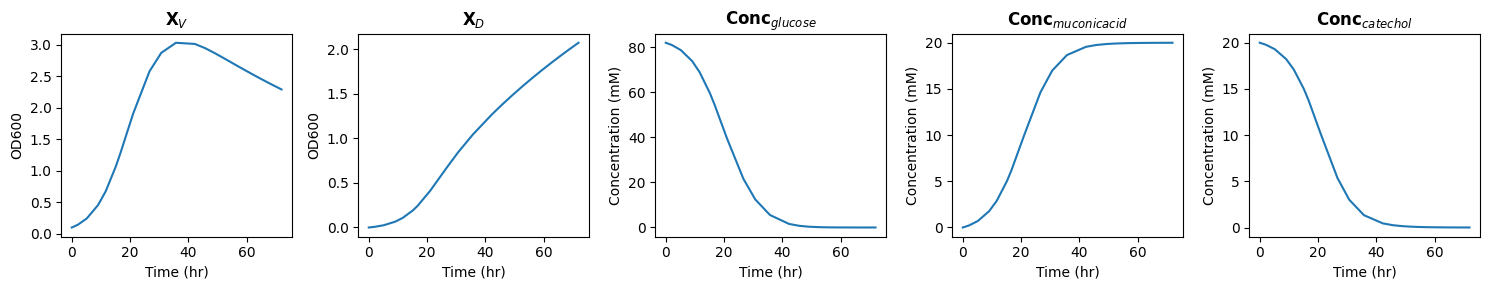

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

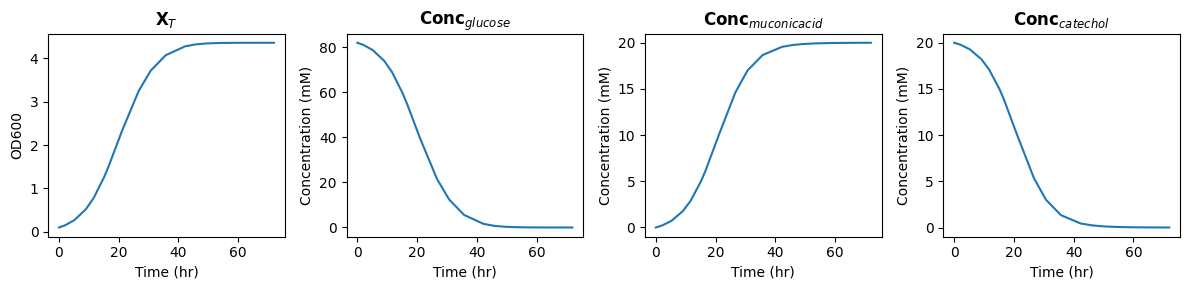

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    """
    This function generates synthetic training data for a 72-hour batch bioprocess.
    It solves the ODE system for different initial conditions provided in a file.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing different initial conditions.
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - sol_dict (dict): Dictionary containing simulated state trajectories for each set of initial conditions.
    """
    
    # Define the directory path to the initial conditions file
    dir_n = "Initial_conditions\\" + file_name  
    
    # Load the initial conditions from the specified file
    Init_cond = np.loadtxt(dir_n)  

    # Initialize dictionaries to store solutions and other parameters
    sol_dict = {}  # Stores simulation results for different initial conditions
    mu_dict = {}   # (Not used in this function, but could store growth rates if needed)

    # Loop through each set of initial conditions
    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i, :]  # Extract initial conditions for this iteration
        tspan = (0, 72)  # Define the simulation time span (0 to 72 hours)
        teval = np.linspace(tspan[0], tspan[1], num_points)  # Generate time points for evaluation
        
        # Solve the ODE system using the Radau method (for stiff systems)
        sol = solve_ivp(
            combined_ode_system,  # ODE function
            tspan,                # Time range
            y0,                   # Initial conditions
            args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument
            method="Radau",       # Implicit solver for stiff ODEs
            t_eval=teval          # Specify time points for evaluation
        )
        
        # Process the solution data
        y_act = sol.y
        y_act[0, :] = y_act[0, :] + y_act[1, :]  # Combine viable (Xv) and dead (Xd) cell counts
        y_act = np.delete(y_act, 1, axis=0)  # Remove the dead cell row (Xd) after merging

        # Store the processed solution in the dictionary
        sol_dict[i] = y_act
        
        time = sol.t  # Store the time points for reference
    
    return [time, sol_dict]  # Return the time points and the dictionary of solutions

In [7]:
def Error_addition(num_points, file_name, per_err, rs=10):
    """
    This function generates synthetic training data using the ODE solver, then adds Gaussian noise (error) 
    to the resulting concentration profiles to simulate real-world data variation.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing initial conditions.
    - per_err (float): The percentage error to be added to the data (as a proportion).
    - rs (int): Random seed for reproducibility (default is 10).
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - retreived_conc_dict (dict): Dictionary with noisy concentration profiles for each initial condition.
    """
    
    # Set the random seed for reproducibility
    random_seed = rs  
    
    # Generate the synthetic training data using the function 'syn_data_generation'
    time, s_dict = syn_data_generation(num_points, file_name)  
    
    # Extract the shape of the concentration profiles (number of species, number of time points)
    num_sp, num_t = np.shape(s_dict[0])

    # Dictionary to store the noisy concentration profiles
    retreived_conc_dict = {}

    # Iterate over each initial condition (batch run) to add error
    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed + i)  # Ensure each batch gets a different seed for randomness
        
        # Generate Gaussian noise (random error) with mean 0 and standard deviation 'per_err'
        D_err = np.random.normal(0, per_err, size=(num_sp, num_t)) / 100
        
        # Get the concentration profiles for the current set of initial conditions
        conc_profiles = s_dict[i]
        
        # Apply the error (element-wise multiplication of concentrations and noise)
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)  # Add noise to the profiles

        # Store the noisy concentration profiles in the dictionary
        retreived_conc_dict[i] = D_final

    # Return the time points and the dictionary containing the noisy concentration profiles
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

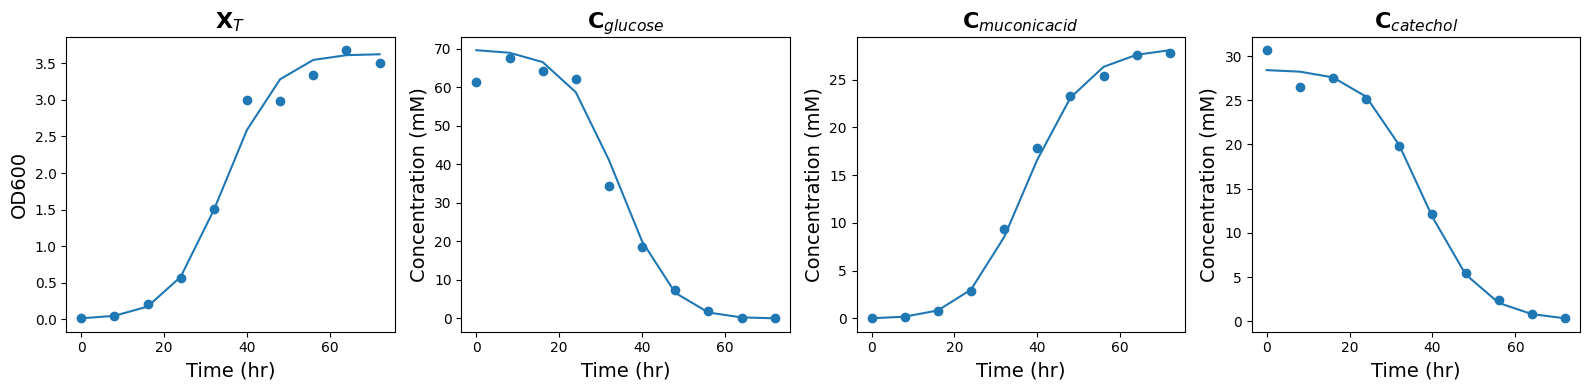

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model, d, t):
    """
    This function represents an integrated Artificial Neural Network (ANN) model 
    that will be embedded within a Pyomo formulation.
    
    Parameters:
    model: Pyomo model containing ANN parameters and variables
    d: Index representing a specific data point or scenario
    t: Index representing a specific time step
    
    Returns:
    h3: Output of the ANN model at the given indices (d, t)
    """

    # Extracting input variables from the Pyomo model
    Xt = model.conc_Xt[d, t]  # Concentration of Xt
    Cg = model.conc_Cg[d, t]  # Concentration of Cg
    Cm = model.conc_Cm[d, t]  # Concentration of Cm
    Cc = model.conc_Cc[d, t]  # Concentration of Cc

    h1_list = []  # List to store activations of the first hidden layer

    # Calculating the first hidden layer activations
    for i in model.h1_num_nod:
        # Weighted sum of inputs plus bias for each node in the first hidden layer
        z1 = (
            model.W1[0, i] * Xt +
            model.W1[1, i] * Cg +
            model.W1[2, i] * Cm +
            model.W1[3, i] * Cc +
            model.b1[i]
        )
        
        # Activation function (Sigmoid function used here)
        h1 = 1 / (1 + math.e ** (-1 * z1))  
        # Alternative activation function (commented out):
        # h1 = (math.e**(2*z1) - 1) / (math.e**(2*z1) + 1)  # Tanh activation function
        
        h1_list.append(h1)  # Storing the computed activation

    # Calculating the output layer activation
    z2 = model.b2  # Initializing with bias term
    for i in model.h1_num_nod:
        z2 += model.W2[i] * h1_list[i]  # Weighted sum of hidden layer activations

    h3 = z2  # Output of the ANN model
    
    return h3  # Returning the final output

In [11]:
def dXtdt_int_con(model, d, t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    return model.dXtdt[d, t] == mu * model.conc_Xt[d, t]  # Defines the biomass growth rate equation

def dCgdt_int_con(model, d, t):
    # Defines a constraint for glucose concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model    
    # Defines the glucose consumption rate equation
    return model.dCgdt[d, t] == -1 * model.conc_Xt[d, t] * (mu * model.Ygx) * (model.max_vals[0] / model.max_vals[1])

def dCmdt_int_con(model, d, t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    # Defines the muconic acid production rate equation
    return model.dCmdt[d, t] == (model.Ymx * mu + model.beta) * model.conc_Xt[d, t] * (
        (model.conc_Cc[d, t]) / (model.conc_Cc[d, t] + (model.kc / model.max_vals[3]))
    ) * (model.max_vals[0] / model.max_vals[2])

def dCcdt_int_con(model, d, t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d, t] == -1 * model.dCmdt[d, t] * (model.max_vals[2] / model.max_vals[3])

def objective_int_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

In [12]:
def make_model_int_rs_fl(rs, fl):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach. 
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Number of time points per initial condition
    err = 10  # Percentage of Gaussian noise to be added
    rs = rs   # Use the random seed specified

    # Generate the synthetic training data using the functions `syn_data_generation` and `Error_addition`.
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    # Collect data for each concentration (Xt, Cg, Cm, Cc) into a temporary list.
    y_temp = []
    for i in range(3):  # Loop for the first three species (Xt, Cg, Cm)
        y_temp.append(rc[i])

    # Convert the temporary data into numpy arrays for easier manipulation
    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    # Get the shape of the data (dimensions for species, datasets, and time points)
    n_d, n_s, n_t = np.shape(no_touch_y)

    # Extract the time and species data
    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis=0), axis=1)  # Get the maximum values for scaling

    # Scale the data for training purposes
    y_scaled = np.zeros(np.shape(y_temp))

    # Create dictionaries for each concentration to store data in a format that Pyomo can use
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    # Normalize each concentration by dividing by its max value
    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j, t[i])] = y_temp[j, 0, i] / max_vals[0]
            y_scaled[j, 0, i] = y_temp[j, 0, i] / max_vals[0]

            Cg_dict[(j, t[i])] = y_temp[j, 1, i] / max_vals[1]
            y_scaled[j, 1, i] = y_temp[j, 1, i] / max_vals[1]

            Cm_dict[(j, t[i])] = y_temp[j, 2, i] / max_vals[2]
            y_scaled[j, 2, i] = y_temp[j, 2, i] / max_vals[2]

            Cc_dict[(j, t[i])] = y_temp[j, 3, i] / max_vals[3]
            y_scaled[j, 3, i] = y_temp[j, 3, i] / max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize the Pyomo model
    num_nodes = 1  # Number of nodes in the hidden layer of the ANN
    model = ConcreteModel()

    # Define sets describing the dataset
    model.d_idx = Set(initialize=range(n_d))  # Batch indices
    model.t_meas = Set(initialize=no_touch_t)  # Time indices

    # Define sets for the integrated ANN structure
    model.h1_num_nod = Set(initialize=range(num_nodes))  # Hidden layer nodes
    model.num_inputs = Set(initialize=range(n_s))  # Input variables (species concentrations)

    # Parameters: Maximum values for scaling, and measured concentration data
    model.max_vals = Param(range(4), initialize=max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize=Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize=Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize=Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize=Cc_dict)

    # Variables - Time invariant parameters related to the bioprocess
    model.Ygx = Var(within=NonNegativeReals)
    model.Ymx = Var(within=NonNegativeReals)
    model.beta = Var(within=NonNegativeReals)
    model.kc = Var(within=NonNegativeReals)

    # Variables for species concentrations and their derivatives
    model.time = ContinuousSet(initialize=model.t_meas, bounds=(0, 72))  # Time range (0 to 72 hours)

    model.conc_Xt = Var(model.d_idx, model.time, within=NonNegativeReals)  # Biomass concentration
    model.conc_Cg = Var(model.d_idx, model.time, within=NonNegativeReals)  # Glucose concentration
    model.conc_Cm = Var(model.d_idx, model.time, within=NonNegativeReals)  # Muconic acid concentration
    model.conc_Cc = Var(model.d_idx, model.time, within=NonNegativeReals)  # Catechol concentration

    # Derivative variables for each concentration
    model.dXtdt = DerivativeVar(model.conc_Xt, within=Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within=Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within=Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within=Reals)

    # Variables for ANN weights and biases (used in growth rate calculations)
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds=(-1, 1))
    model.b1 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.W2 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.b2 = Var(bounds=(-1, 1))

    # Constraints - Hybrid ODEs for each species (biomass, glucose, muconic acid, catechol)
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule=dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule=dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule=dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule=dCcdt_int_con)

    # Objective - State space MSE (Mean Squared Error) for model fitting
    model.obj = Objective(expr=objective_int_SSmse)

    # Discretizer for Pyomo.DAE (Differential-Algebraic Equations)
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=n_t, ncp=2, scheme='LAGRANGE-RADAU')  # Apply Lagrange-Radau collocation method

    # Solver setup - Multistart solver (for better convergence in nonlinear models)
    solver = SolverFactory("multistart")
    results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)

    # Print solver status and results
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))  # Print the objective function value

    # Return the model and max values for future scaling or testing
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    """
    Extracts the time-invariant parameters and ANN weights/biases from an integrated Pyomo model.
    
    Parameters:
    - model: The integrated Pyomo model, which includes both ODEs and the embedded ANN.
    
    Returns:
    - TIV_params: Dictionary containing time-invariant model parameters (Ygx, Ymx, beta, kc).
    - ANN_params: Dictionary containing the ANN weights and biases (W1, b1, W2, b2).
    """
    
    TIV_params = {}

    # Extract time-invariant parameters from the model and store them in a dictionary
    TIV_params["Ygx"] = value(model.Ygx)  # Yield coefficient for glucose consumption
    TIV_params["Ymx"] = value(model.Ymx)  # Yield coefficient for muconic acid production
    TIV_params["beta"] = value(model.beta)  # Growth-associated production rate for muconic acid
    TIV_params["kc"] = value(model.kc)  # Constant associated with catechol consumption

    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize arrays for the ANN weights and biases
    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))  # Input-to-hidden layer weights
    b1 = np.zeros((len(model.h1_num_nod), 1))  # Hidden layer biases
    W2 = np.zeros((len(model.h1_num_nod), 1))  # Hidden-to-output layer weights

    # Extract the values for weights and biases from the model
    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i, j] = value(model.W1[i, j])  # Weight for input-to-hidden layer connection

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])  # Bias for the hidden layer
        W2[i] = value(model.W2[i])  # Weight for hidden-to-output layer connection

    # Store the extracted weights and biases in the ANN_params dictionary
    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)  # Bias for the output layer

    # Return the extracted parameters
    return [TIV_params, ANN_params]

## Integrated model assembly and testing

In [14]:
def ANN_int_growth_model(y, ANN_params):
    # This function calculates the total biomass growth rate using an artificial neural network (ANN)
    # It takes inputs: Xt (biomass concentration), Cg (glucose concentration), Cm (muconic acid concentration),
    # Cc (catechol concentration), and the weights and biases of the ANN
    
    Xt, Cg, Cm, Cc = y  # Extract input values from the input vector y
    
    # Extract weights and biases from the ANN parameters dictionary
    W1 = ANN_params["W1"]
    b1 = ANN_params["b1"]
    W2 = ANN_params["W2"]
    b2 = ANN_params["b2"]
    
    h1_list = []  # List to store the outputs of the first hidden layer
    
    # Compute the outputs of the first hidden layer (h1) using the inputs and the ANN weights/biases
    for i in range(np.shape(b1)[0]):
        # Compute the weighted sum (z1) for each neuron in the first hidden layer
        z1 = W1[0, i] * Xt + W1[1, i] * Cg + W1[2, i] * Cm + W1[3, i] * Cc + b1[i, 0]
        # Apply the sigmoid activation function to z1
        h1 = (1 / (1 + math.e**(-1 * z1)))  # Sigmoid activation function
        h1_list.append(h1)  # Store the output of the hidden layer neuron
    
    # Compute the output (z2) of the second layer
    z2 = b2
    for i in range(np.shape(W2)[0]):
        # Compute the weighted sum for the output layer
        z2 += W2[i, 0] * h1_list[i]
    
    # Return the final output, which is the total biomass growth rate (h3)
    h3 = z2
    return h3

In [15]:
def Int_HM_ODE(t, y, param_dict, ANN_params, max_vals):
    # Defines the system of ODEs that simulate the hybrid model
    # and return the rates of change for the species in the system
    
    Xt, Cg, Cm, Cc = y  # Extracts the current concentrations of biomass (Xt),
                         # glucose (Cg), muconic acid (Cm), and catechol (Cc)
    
    # Extracts relevant parameters from the parameter dictionary
    Ygx = param_dict["Ygx"]  # Yield coefficient for glucose consumption
    Ymx = param_dict["Ymx"]  # Yield coefficient for muconic acid production
    beta = param_dict["beta"]  # Basal production rate for muconic acid
    kc = param_dict["kc"]  # Saturation constant for catechol inhibition
    
    # Computes the specific growth rate (mu) using the ANN model
    mu = ANN_int_growth_model(y, ANN_params)
    
    # Defines the differential equations for the system:
    
    # Rate of change of biomass concentration
    dXtdt = mu * Xt
    
    # Rate of change of glucose concentration
    dCgdt = -1 * Xt * (mu * Ygx) * (max_vals[0] / max_vals[1]) 
    
    # Rate of change of muconic acid concentration
    dCmdt = (Ymx * mu + beta) * Xt * ((Cc) / (Cc + (kc / max_vals[3]))) * (max_vals[0] / max_vals[2])
    
    # Rate of change of catechol concentration (which is consumed as muconic acid is produced)
    dCcdt = -1 * dCmdt
    
    # Returns the list of rates of change for each species
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [16]:
def Int_HM_Org_model_comparison_time(y0, tdict, adict, max_vals): 
    # This function simulates a batch extrapolation scenario for a given initial condition
    # and compares the integrated hybrid model's predictions with the ground truth model.
    # It returns the R2 value (coefficient of determination) as a measure of model fit.
    
    y0 = y0  # Initial conditions for the system
    y0_4 = np.delete(y0, 1)  # Removes the second element from the initial conditions (possibly corresponding to glucose)
    tspan = (0, 200)  # Defines the time span for the simulation
    
    # Solves the ground truth ODE system using the actual model
    # It integrates over the time span, using the initial condition y0[2] as an argument for the ground truth model
    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args=tuple([y0[2]]),
                           method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_actual = sol_actual.y  # Extracts the solution (species concentrations)
    
    # Adjusts the biomass concentration by adding back the deleted glucose concentration component
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]
    
    # Deletes the second row (possibly glucose) to match the format used in predictions
    y_actual = np.delete(y_actual, 1, axis=0)
    
    # Scales the initial condition by the maximum values for normalization
    y0_scaled = np.divide(y0_4, max_vals)
    
    # Solves the integrated hybrid model ODE system (predicted model)
    # Uses the scaled initial conditions and the provided parameter dictionaries (tdict, adict)
    sol_predict = solve_ivp(Int_HM_ODE, tspan, y0_scaled, args=tuple([tdict, adict, max_vals]),
                            method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescales the predicted output
    
    r2_list = []  # List to store R2 scores for each species
    
    # Loops through each species and calculates the R2 score between actual and predicted values
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))
    
    # Returns the mean R2 score across all species, which indicates the overall model performance
    return np.mean(r2_list)

In [17]:
def Int_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    # This function simulates a semi-batch extrapolation scenario for the integrated hybrid ODE model
    # The semi-batch process involves periodic glucose and catechol spikes at specific time intervals
    # It compares the predictions from the integrated hybrid model to the ground truth model and returns the R2 value
    
    y0 = y0  # Initial conditions for the system
    y0_4 = np.delete(y0, 1)  # Removes the second element (likely glucose) from the initial condition for the scaled model
    tspan = (0, 200)  # Defines the overall simulation time span
    
    sol_list = []  # List to store solutions from the ground truth ODE system
    t_init = 0  # Initial time for each semi-batch
    t_fin = 25  # Final time for each semi-batch (periodic input spikes every 25 hours)
    count = 0  # Counter for the number of input spikes
    y0_org = y0[2]  # Stores the initial concentration of muconic acid
    
    # Loop to simulate the semi-batch process, iterating through multiple 25-hour periods
    while t_fin <= tspan[-1]:
        # Solves the ground truth ODE system for each 25-hour period with a glucose and catechol spike
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args=tuple([y0_org + 10 * count]),
                               method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        
        sol_list.append(sol_actual)  # Adds the solution to the list
        
        y0 = np.copy(sol_actual.y[:, -1])  # Updates the initial condition for the next iteration
        y0[2] += 10  # Adds glucose spike
        y0[-1] += 3  # Adds catechol spike
        
        t_init += 25  # Updates time for the next semi-batch period
        t_fin += 25  # Updates final time for the next semi-batch period
    
    # Collects the results from all time periods into a single array
    y = np.zeros((5, 80))  # Placeholder for the actual data (5 species and 80 time steps)
    t = []  # Placeholder for time values
    for i in range(len(sol_list)):
        s = 10 * i  # Start index for the time slice
        e = 10 * (i + 1)  # End index for the time slice
        y[:, s:e] = sol_list[i].y  # Stores the solution for each time slice
        t.append(sol_list[i].t)  # Stores the corresponding time values
    
    t_actual = np.array(t).reshape(-1,)  # Reshapes the time array for consistency
    
    # Adjusts the actual solution array for species concentrations (combines biomass and glucose)
    y_actual = np.copy(y)
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]
    y_actual = np.delete(y_actual, 1, axis=0)  # Deletes the glucose concentration row (already combined)
    
    # Initializes variables for the predicted model simulation
    sol_list = []
    t_init = 0
    t_fin = 25
    y_predict = np.zeros((4, 80))  # Placeholder for the predicted values (4 species)
    t = []  # Placeholder for predicted time values
    c = 0  # Counter for time steps
    
    # Loop to simulate the semi-batch process for the integrated hybrid model
    while t_fin <= tspan[-1]:
        # Scales the initial conditions by the maximum values
        y0_scaled = np.divide(y0_4, max_vals)
        
        # Solves the integrated hybrid model ODE system for each 25-hour period with spikes
        sol_predict = solve_ivp(Int_HM_ODE, (t_init, t_fin), y0_scaled, args=tuple([tdict, adict, max_vals]),
                                method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescales the predicted output to original units
        
        # Stores the predicted values for the current time period
        y_predict[:, 10 * c:10 * (c + 1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))  # Stores the corresponding time values
        
        y0_4 = np.copy(y_pr[:, -1])  # Updates the initial condition for the next iteration
        y0_4[1] += 10  # Adds glucose spike
        y0_4[-1] += 3  # Adds catechol spike
        
        t_init += 25  # Updates time for the next semi-batch period
        t_fin += 25  # Updates final time for the next semi-batch period
        c += 1  # Increments the time step counter
    
    t_predict = np.array(t).reshape(-1, 1)  # Reshapes the time array for consistency
    
    r2_list = []  # List to store R2 scores for each species
    
    # Calculates the R2 score for each species between the actual and predicted values
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))
    
    # Returns the average R2 score across all species as a measure of model accuracy
    return np.mean(r2_list)

In [18]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [19]:
performance_dict = {}

In [20]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Int_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Int_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.002261065840505239
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.001724892139301745
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.11.1\x3a Maximum Number of Iterations
      Exceeded.
Solver status: ok
Termination Condition: optimal
0.0023019268443607546
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0026972391223319433
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0030454389655592607
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Termination Condition: optimal
0.00215827396026379
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0016889967183419071
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solve

In [21]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

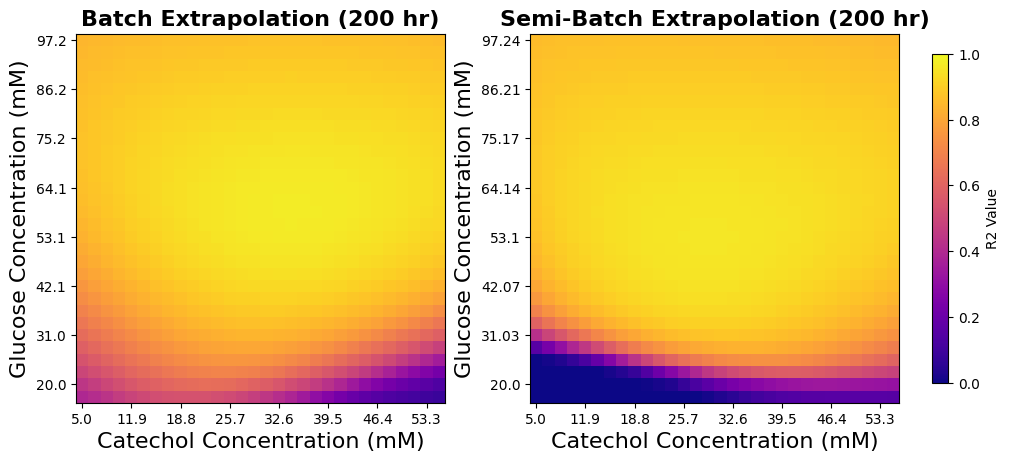

In [22]:
# The data made in the previous box
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [23]:
final_dict = {}
final_dict["HMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Sequential model construction

In [24]:
def dXtdt_seq_con(model, d, t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    mu = model.mu[d,t]
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t] # Defines the biomass growth rate equation

def dCgdt_seq_con(model,d,t):
    # Defines a constraint for glucose concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    mu = model.mu[d,t]
    # Defines the glucose consumption rate equation
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_seq_con(model,d,t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    mu = model.mu[d,t]
    # Defines the muconic acid production rate equation
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_seq_con(model,d,t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_seq_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

def objective_seq_smoothing(model):
    # This function defines a smoothing objective for the sequential model, 
    # aiming to penalize large changes in the growth rate (mu) over time.
    # Initialize the objective function value to 0
    final = 0
    # Loop over all species (d_idx) in the model
    for i in model.d_idx:
        # Loop over the time steps (excluding the first two and last two) for each species
        for j in range(len(model.time)-2):
            k = j + 1  # Set k to represent the current time step in the loop
            # Compute the second-order difference in growth rates (mu) between three consecutive time points
            # This penalty term helps to smooth out large variations in mu
            final += (model.mu[i,model.time[k+2]] - 2*model.mu[i, model.time[k+1]] + model.mu[i, model.time[k]])**2
    # Average the final value by the total number of species and the number of relevant time steps
    fin = final/(len(model.d_idx)*(len(model.time)-3))
    # Return the objective function value
    return fin

def combined_seq_objective(model):
    # This function defines a multi-objective optimization formulation for the sequential model.
    # The objective is a weighted sum of two separate objectives: 
    # one based on model fitting (SSmse) and one based on smoothing (mu).
    
    # Set weights for the two objectives: w1 and w2
    w1 = 1  # Weight for the model fitting objective (SSmse)
    w2 = 10 # Weight for the smoothing objective (mu)
    
    # Calculate the first objective (model fitting based on SSmse)
    o1 = objective_seq_SSmse(model)
    # Calculate the second objective (smoothing of the growth rate)
    o2 = objective_seq_smoothing(model)
    # Return the combined objective as a weighted sum of the two objectives
    return w1*o1 + w2*o2

In [25]:
def make_model_seq_rs_fl(rs, fl):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach. 
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - y_scaled: The scaled training data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Set the number of data points (could be for the time steps or the species)
    err = 10  # Set the error magnitude for generating noisy data
    rs = rs    # Assign the provided random seed for reproducibility

    # Generate synthetic data using initial conditions (syn_data_generation) and add error (Error_addition)
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []  # List to store data for later scaling

    # Store relevant data (rc) for further processing
    for i in range(3):
        y_temp.append(rc[i])

    # Convert list to numpy array for easier manipulation
    no_touch_y = np.array(y_temp)
    no_touch_t = t  # Time vector remains unchanged

    # Get the shape of the training data (d, s, t)
    n_d, n_s, n_t = np.shape(no_touch_y)

    # Prepare the time and data for scaling
    t = no_touch_t
    y_temp = no_touch_y

    # Find the maximum values in the dataset for scaling
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))  # Initialize an empty array for scaled data

    # Convert the numpy data into dictionaries for easier usage in the Pyomo model
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    # Populate dictionaries with scaled data for the different concentrations (Xt, Cg, Cm, Cc)
    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Create a ConcreteModel in Pyomo to define the optimization problem
    model = ConcreteModel()

    # Define the sets for the species (d_idx) and the time measurements (t_meas)
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Parameters: maximum values for scaling and the measured concentration values (Xt, Cg, Cm, Cc)
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables for time-invariant parameters
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Variables for the concentrations and their derivatives over time
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.mu = Var(model.d_idx, model.time, within = NonNegativeReals)

    # Derivative variables for the concentrations
    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Constraints representing the hybrid ODE system
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_seq_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_seq_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_seq_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_seq_con)

    # Objective function based on the combined sequence objectives (model fitting and smoothing)
    model.obj = Objective(expr = combined_seq_objective)

    # Apply the discretization for the Pyomo model using collocation (Lagrange-Radau scheme)
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=n_t, ncp=1, scheme='LAGRANGE-RADAU')

    # Use a solver to find optimal parameters
    solver = SolverFactory("multistart")
    results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)

    # Output solver status and results
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))

    # Return the maximum values, scaled training data, and the Pyomo model
    return [max_vals, y_scaled, model]

In [26]:
def TIV_and_ANN_seq_model(y_scaled, max_vals, model):
    
    # This function extracts time-invariant parameters from the integrated Pyomo model 
    # and uses a supervised regression model (ANN) to predict the growth rate (mu) over time.

    TIV_params = {}

    # Extract time-invariant parameters from the model and store them in a dictionary
    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Extract the discrete time-varying growth rate parameter (mu) from the model
    # and create a dataset (X, y) for use in a supervised regression model.
    
    X = []  # Input features (scaled concentrations)
    y = []  # Output target (growth rate, mu)

    # Iterate through the species (d_idx) and time measurements (t_meas)
    for i in model.d_idx:
        for j in range(len(model.t_meas)):
            # Append the growth rate (mu) and scaled concentration data
            y.append(value(model.mu[i,model.t_meas[j+1]]))
            X.append(y_scaled[i,:,j])

    # Reshape the target variable 'y' to be a 2D array (for regression)
    y = np.array(y).reshape(-1,1)
    
    # Rescale the inputs (X) using the maximum values for scaling
    X = np.multiply(np.array(X), max_vals.reshape(1,-1))

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Split the dataset into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # Standardize the inputs and outputs using training data statistics
    SS_x = StandardScaler()
    SS_y = StandardScaler()

    # Fit and transform the training data, and transform the test data
    X_train_scaled = SS_x.fit_transform(X_train)
    X_test_scaled = SS_x.transform(X_test)

    # Fit and transform the target variable (y) for training and testing
    y_train_scaled = SS_y.fit_transform(y_train)
    y_test_scaled = SS_y.transform(y_test)
    
    # Set up grid search for tuning the ANN (MLPRegressor) hyperparameters for the growth rate (mu)
    mlp = MLPRegressor(early_stopping = True,
                       max_iter = 10000,
                       random_state = 42, 
                       shuffle = True,
                       validation_fraction = 0.2)

    # Generate possible hidden layer structures (combinations of nodes per layer)
    hls = []
    numnodes = np.arange(1, 11)  # Number of nodes in the hidden layers

    for i in numnodes:
        hls.append(tuple([i]))  # Single hidden layer with 'i' nodes
        for j in numnodes:
            hls.append(tuple([i, j]))  # Two hidden layers with 'i' and 'j' nodes

    # Define the parameter grid for the grid search
    param_grid = {
        "hidden_layer_sizes": hls,
        "activation": ["tanh", "logistic"],  # Activation functions to test
        "alpha": np.logspace(-5, -2, 4)  # Regularization parameter values to test
    }
    
    # Set up the grid search for hyperparameter tuning
    grid_search = GridSearchCV(mlp, 
                               param_grid,
                               n_jobs = -1,
                               verbose = 3,
                               return_train_score = True
                              )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train_scaled, y_train_scaled.reshape(-1,))

    # Get the best estimator from the grid search
    best_estimator = grid_search.best_estimator_

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Standardize all the data (X and y) and fit the best estimator (ANN) on the full dataset
    
    SS_x = StandardScaler()
    SS_y = StandardScaler()

    # Standardize the entire dataset
    X_scaled = SS_x.fit_transform(X)
    y_scaled = SS_y.fit_transform(y)

    # Fit the best model found from grid search on the entire data
    best_estimator.fit(X_scaled, y_scaled.reshape(-1,))

    # Return the time-invariant parameters, the scaler objects, and the trained ANN model
    return [TIV_params, SS_x, SS_y, best_estimator]

## Sequential model assembly and testing

In [27]:
def ANN_seq_growth_model(x, SS_X, SS_y, BB_HM_model, max_vals):
    
    # This function takes in the input concentrations (Xt, Cg, Cm, Cc), 
    # along with a trained ANN model to predict the total biomass growth rate.

    tempx = []  # Initialize a list to store scaled input values
    
    # Scale the input values (x) using the maximum values for each concentration
    for i in range(len(x)):
        tempx.append(x[i] * max_vals[i])  # Multiply each input by its respective max value
    
    tempx = np.array(tempx)  # Convert the list to a numpy array
    
    # Standardize the scaled inputs using the provided SS_X (Standard Scaler for X inputs)
    tempx_scaled = SS_X.transform(tempx.reshape(1, -1))  # Reshape the input to match the scaler's expected format
    
    # Use the trained ANN model (BB_HM_model) to predict the scaled growth rate (mu)
    y_predict_scaled = BB_HM_model.predict(tempx_scaled)
    
    # Inverse transform the scaled prediction to get the actual growth rate (mu)
    y_predict = SS_y.inverse_transform(y_predict_scaled.reshape(1, -1))
    
    return y_predict  # Return the predicted growth rate (mu) in its original scale

In [28]:
def Seq_HM_ODE(t, y, param_dict, SS_X, SS_y, BB_HM_model, max_vals):
    
    # This function defines the system of ordinary differential equations (ODEs)
    # for a hybrid model that includes an Artificial Neural Network (ANN) 
    # for predicting the biomass growth rate and returns the gradients of
    # the changing species concentrations over time.

    # Extract current species concentrations from the state vector (y)
    Xt, Cg, Cm, Cc = y  # Xt: total biomass, Cg: glucose, Cm: metabolite, Cc: waste concentration
    
    # Extract time-invariant parameters from the dictionary (param_dict)
    Ygx = param_dict["Ygx"]  # Yield coefficient for biomass on glucose
    Ymx = param_dict["Ymx"]  # Yield coefficient for biomass on metabolite
    beta = param_dict["beta"]  # Metabolite production coefficient
    kc = param_dict["kc"]  # Half-saturation constant for waste
    
    # Get the growth rate (mu) using the trained ANN model and scaling functions
    mu = ANN_seq_growth_model(y, SS_X, SS_y, BB_HM_model, max_vals)[0][0]  # Predicted growth rate from ANN

    # Define the ODEs for the system:
    # 1. Biomass concentration change (dXtdt) depends on growth rate (mu) and biomass (Xt)
    dXtdt = mu * Xt  # Rate of change of total biomass
    # 2. Glucose concentration change (dCgdt) depends on biomass (Xt), growth rate (mu), 
    #    and yield coefficient (Ygx). Also scaled by the max values.
    dCgdt = -1 * Xt * (mu * Ygx) * (max_vals[0] / max_vals[1])  # Consumption of glucose by biomass
    # 3. Metabolite concentration change (dCmdt) depends on biomass (Xt), growth rate (mu),
    #    metabolite yield coefficient (Ymx), the waste concentration (Cc), and half-saturation constant (kc).
    dCmdt = (Ymx * mu + beta) * Xt * ((Cc) / (Cc + (kc / max_vals[3]))) * (max_vals[0] / max_vals[2])  # Metabolite production
    # 4. Waste concentration change (dCcdt) is the negative of the metabolite concentration change
    dCcdt = -1 * dCmdt  # Waste is produced as the metabolite is consumed

    # Return the rates of change (gradients) for each species
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [29]:
def Seq_HM_Org_model_comparison_time(y0, tdict, SS_X, SS_y, ANN, max_vals): 
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condition using the sequential hybrid ODE model. The function 
    # compares the predicted output of the hybrid model with the ground truth model 
    # and returns the R² value between the two for the same initial conditions.

    # Initial condition for the species (Xt, Cg, Cm, Cc)
    y0 = y0
    
    # Remove the second element (Cg) from the initial conditions for the comparison
    y0_4 = np.delete(y0, 1)  # Remove glucose concentration (Cg)
    
    # Time span for the simulation (0 to 200)
    tspan = (0, 200)

    # Solve the ODE system for the actual model (ground truth)
    # Using 'solve_ivp' to integrate the combined system (combined_ode_system)
    # The `combined_ode_system` function models the ground truth, and tdict contains
    # relevant parameters for the ODE system.
    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args=tuple([y0[2]]), 
                           method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    
    # Extract the solution from the ODE solver
    y_actual = sol_actual.y
    # Combine the first two rows (biomass and glucose) into one (Xt)
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]
    # Remove the second row (glucose) from the solution
    y_actual = np.delete(y_actual, 1, axis=0)

    # Scale the initial condition by the maximum values (max_vals)
    y0_scaled = np.divide(y0_4, max_vals)  # Scale by the max values to match model's scaling

    # Solve the ODE system for the predicted model (sequential hybrid model)
    # The Seq_HM_ODE function is used to predict concentrations using the trained ANN
    sol_predict = solve_ivp(Seq_HM_ODE, tspan, y0_scaled, args=tuple([tdict, SS_X, SS_y, ANN, max_vals]),
                            method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    
    # Multiply the predicted solution by max_vals to scale back to original concentrations
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))

    # Initialize an empty list to store R² values for each species
    r2_list = []
    
    # Calculate the R² score for each species (Xt, Cg, Cm, Cc) between actual and predicted values
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))  # Compute R² for each species

    # Return the average R² value over all species
    return np.mean(r2_list)

In [30]:
def Seq_HM_Org_model_comparison_FB(y0, tdict, SS_X, SS_y, ANN, max_vals): 
    
    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condition using the sequential hybrid ODE model. The semi-batch
    # process includes a spike input of glucose (10 mM) and catechol (3 mM) every 25 hours.
    # The function compares the predicted output of the hybrid model with the ground truth model
    # and returns the R² value between the two for the same initial conditions.

    # Initial condition for the species (Xt, Cg, Cm, Cc)
    y0 = y0
    
    # Remove glucose (Cg) concentration from the initial condition for the comparison
    y0_4 = np.delete(y0, 1)  # Remove glucose concentration (Cg)
    
    # Time span for the simulation (0 to 200)
    tspan = (0, 200)

    # Initialize the solution list, start and end times for the spike input (0-25 hours)
    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0
    y0_org = y0[2]  # Initial metabolite concentration

    # Run the simulation for each 25-hour period, applying the glucose and catechol spikes
    while t_fin <= tspan[-1]:
        # Solve the ODE system for the actual model (ground truth)
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args=tuple([y0_org + 10*count]), 
                               method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        sol_list.append(sol_actual)  # Append the solution to the list

        # Update the initial condition for the next time step
        y0 = np.copy(sol_actual.y[:, -1])  # Get the last values from the previous simulation
        y0[2] += 10  # Add glucose spike
        y0[-1] += 3  # Add catechol spike

        # Increment the time step
        t_init += 25
        t_fin += 25

    # Construct the actual solution for the entire simulation (80 points)
    y = np.zeros((5, 80))
    t = []
    for i in range(len(sol_list)):
        s = 10 * i
        e = 10 * (i + 1)
        y[:, s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    
    # Reshape the time and actual values
    t_actual = np.array(t).reshape(-1,)
    y_actual = np.copy(y)
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]  # Combine Xt and Cg into biomass (Xt)
    y_actual = np.delete(y_actual, 1, axis=0)  # Remove glucose (Cg)

    # Initialize the solution list for the predicted model
    sol_list = []
    t_init = 0
    t_fin = 25

    # Create an array to store the predicted values
    y_predict = np.zeros((4, 80))
    t = []
    c = 0

    # Run the simulation for each 25-hour period for the predicted model
    while t_fin <= tspan[-1]:
        # Scale the initial conditions by max_vals for the hybrid model
        y0_scaled = np.divide(y0_4, max_vals)
        
        # Solve the ODE system for the predicted model (sequential hybrid model)
        sol_predict = solve_ivp(Seq_HM_ODE, (t_init, t_fin), y0_scaled, 
                                args=tuple([tdict, SS_X, SS_y, ANN, max_vals]),
                                method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        
        # Scale back the predicted values to the original concentrations
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))
        
        # Store the predicted values for this time interval
        y_predict[:, 10 * c:10 * (c + 1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))  # Store the time points

        # Update the initial condition for the next time step
        y0_4 = np.copy(y_pr[:, -1])
        y0_4[1] += 10  # Add glucose spike
        y0_4[-1] += 3  # Add catechol spike

        # Increment the time step
        t_init += 25
        t_fin += 25
        c += 1

    # Reshape the time array for the predicted model
    t_predict = np.array(t).reshape(-1, 1)

    # Calculate the R² score for each species (biomass, glucose, metabolite, waste)
    r2_list = []
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))  # Compute R² for each species

    # Return the average R² value over all species
    return np.mean(r2_list)

In [31]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, y_scaled, model_rs1 = make_model_seq_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, y_scaled, model_rs1 = make_model_seq_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, SS_X, SS_y, ANN = TIV_and_ANN_seq_model(y_scaled, max_vals, model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Seq_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, SS_X, SS_y, ANN, max_vals))
            rect_FB_EX.append(Seq_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, SS_X, SS_y, ANN, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from
C:\Users\slaxminarayan3\AppData\Local\Temp\ipykernel_16280\3357724659.py:62)
Solver status: ok
Termination Condition: optimal
0.0025602304015177376
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from
C:\Users\slaxminarayan3\AppData\Local\Temp\ipykernel_16280\2661345182.py:27)
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.001829129986038795
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.00405305824453573
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002866572844059

C:\Users\slaxminarayan3\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0023413154105147824
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.00303766791367586
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0031706625691229943
Fitting 5 folds for each of 880 candidates, totalling 4400 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [32]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

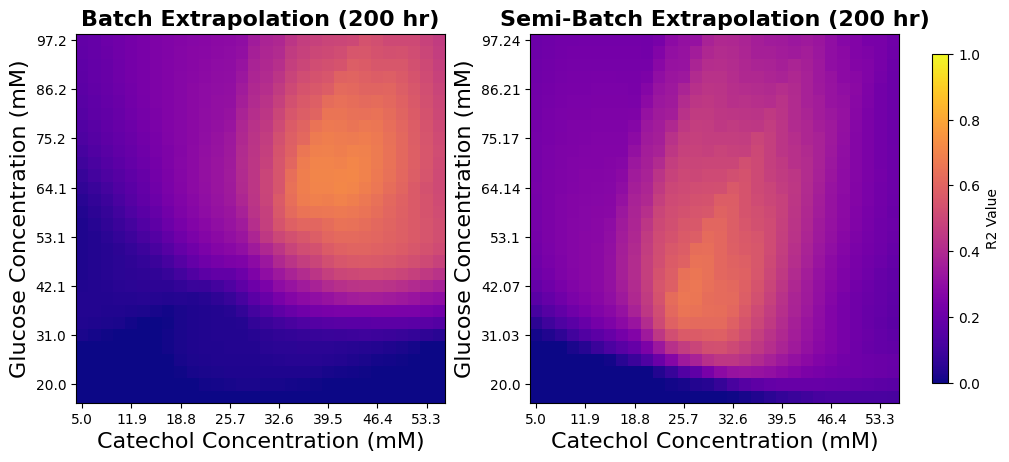

In [33]:
# Data generated in the previous cell
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [34]:
final_dict["HMS_Extrapolation"] = np.array([T_EX, FB_EX])

# Final Performance Evaluation

In [35]:
int_list = []
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for i in file_list:
    fl = "Initial_conditions\\" + i
    int_list.append(np.loadtxt(fl))

In [36]:
a = np.array(int_list)

Cg_min = np.min(a[:,:,2])
Cc_min = np.min(a[:,:,-1])

Cg_max = np.max(a[:,:,2])
Cc_max = np.max(a[:,:,-1])

In [37]:
x_min = (30/50)*(Cc_min - 5)
x_max = (30/50)*(Cc_max - 5)

y_min = (30/80)*(Cg_min - 20)
y_max = (30/80)*(Cg_max - 20)

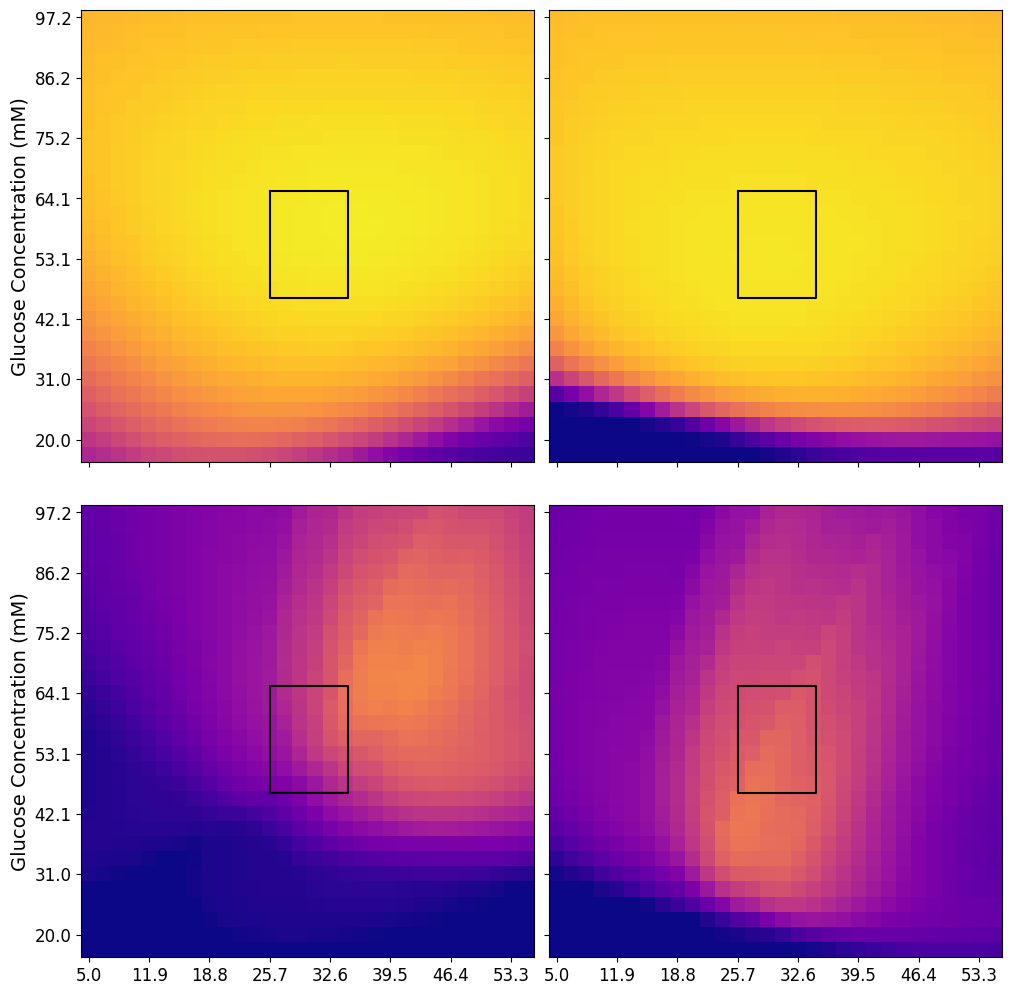

In [38]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Integrated Hybrid", "HMS_Extrapolation" : "Sequential Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][0].reshape(30,30))
    data2 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z,0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,0].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,0].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2: 
        axes[z,0].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,0].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z,0].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    #axes[z,0].set_ylabel(titles[keys[z]], fontsize = 16, fontweight = "bold")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    im2 = axes[z,1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,1].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,1].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2:
        axes[z,1].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,1].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")

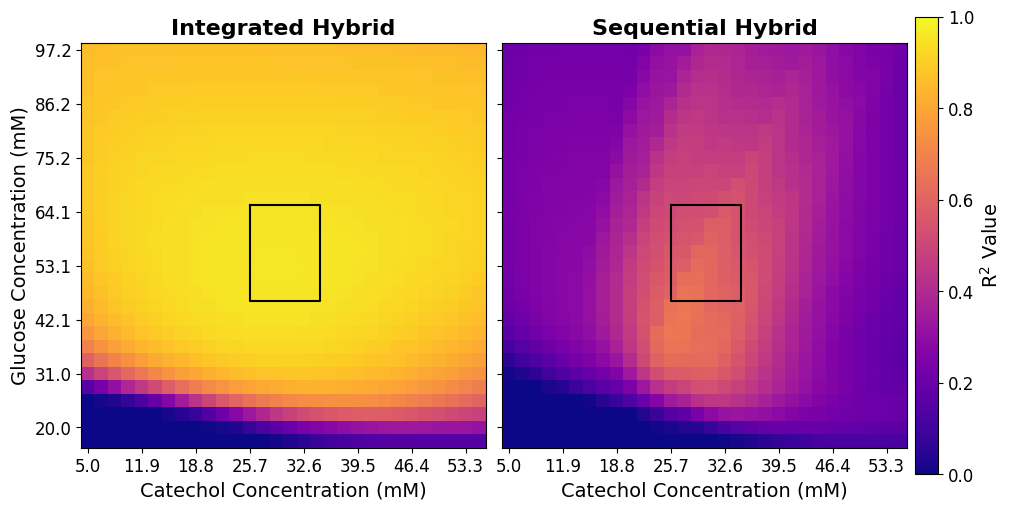

In [39]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Integrated Hybrid", "HMS_Extrapolation" : "Sequential Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12) 
    axes[z].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    if z == 0:
        axes[z].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    axes[z].set_title(titles[keys[z]], fontsize = 16, fontweight = "bold")


    # Add a common color bar
imz = im2
cbar = fig.colorbar(imz, ax=axes, orientation='vertical', fraction=0.07, pad=0.01)
cbar.set_label('R$^2$ Value', fontsize = 14)
cbar.ax.tick_params(labelsize = 12)
plt.savefig("Int_v_Seq.svg")

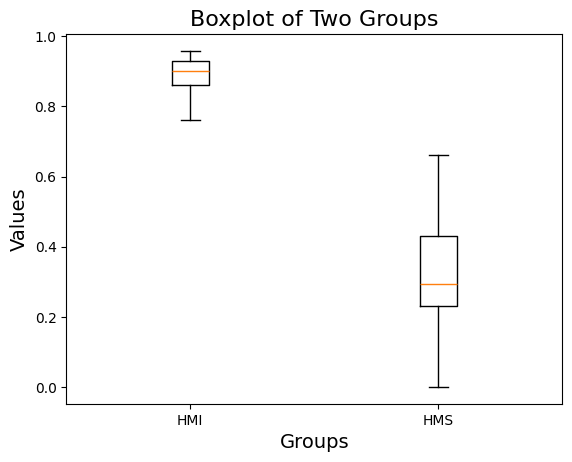

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data for two groups
data1 = final_dict["HMI_Extrapolation"][1]  # Group 1 data
data2 = final_dict["HMS_Extrapolation"][1]

# Combine data into a list for plotting
data = [data1, data2]

# Create the boxplot
#plt.figure(figsize=(8, 6))  # Set figure size
plt.boxplot(data, labels=['HMI', "HMS"], showfliers = False)  # Add labels for the x-axis

# Add axis labels
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Add a title (optional)
plt.title('Boxplot of Two Groups', fontsize=16)

# Show the plot
plt.show()